# Import required libraries

In [1]:
import cv2 as cv
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
from numba import jit
import torch

# Import Stereo Images and Models

In [2]:
l_img = cv.imread('./images/imageL1.png')
r_img = cv.imread('./images/imageR1.png')
model = YOLO("yolo11m-seg.pt")

def viewImages(original, modified): 
    plt.figure(figsize=(9,9)) 

    plt.subplot(1,2,1) 
    plt.imshow(original) 
    plt.title('Orignal') 
    plt.axis('off') 

    plt.subplot(1,2,2) 
    plt.imshow(modified) 
    plt.title("modified") 
    plt.axis('off') 
    plt.tight_layout()

100%|██████████| 43.3M/43.3M [00:01<00:00, 24.4MB/s]


# Stereo Processing Algorithms

In [3]:
# Use SAD Algorithm for calculate disparities ---------------------------------------------------------------
@jit(nopython=True)
def compute_disparity_SAD(left_img, right_img, block_size, disparities):
    h, w = left_img.shape
    disparity = np.zeros((h, w), np.uint8)
    half_block = block_size // 2

    for y in range(half_block, h - half_block):
        for x in range(half_block, w - half_block):
            left_block = left_img[y - half_block:y + half_block + 1,
                                       x - half_block:x + half_block + 1]

            min_sad = block_size ** 2 * 255
            best_disparity = 0

            for d in range(disparities):
                x_right = x - d

                if x_right - half_block >= 0:
                    right_block = right_img[y - half_block:y + half_block + 1,
                                                 x_right - half_block:x_right + half_block + 1]

                    sad = np.sum(np.abs(left_block.astype(np.int32) - right_block.astype(np.int32)))

                    if sad < min_sad:
                        min_sad = sad
                        best_disparity = d

            disparity[y, x] = best_disparity

    return disparity

# Use SSD Algorithm for calculate disparities ---------------------------------------------------------------
@jit(nopython=True)
def compute_disparity_SSD(left_img, right_img, block_size, max_disparity):
    h, w = left_img.shape

    disparity = np.zeros((h, w), np.uint8)

    half_block = block_size // 2

    for y in range(half_block, h - half_block):
        for x in range(half_block, w - half_block):
            left_block = left_img[y - half_block:y + half_block + 1,
                                       x - half_block:x + half_block + 1]

            min_ssd = block_size ** 2 * 255
            best_disparity = 0

            for d in range(max_disparity):
                x_right = x - d

                if x_right - half_block >= 0:
                    right_block = right_img[y - half_block:y + half_block + 1,
                                                 x_right - half_block:x_right + half_block + 1]

                    ssd = np.sum((left_block.astype(np.int32) - right_block.astype(np.int32)) ** 2)

                    if ssd < min_ssd:
                        min_ssd = ssd
                        best_disparity = d
            disparity[y, x] = best_disparity

    return disparity

# Use NCC Algorithm for calculate disparities ---------------------------------------------------------------
@jit(nopython=True)
def compute_disparity_NCC(left_img, right_img, block_size, max_disparity):

    h, w = left_img.shape

    disparity_map = np.zeros((h, w), np.float32)

    half_block = block_size // 2

    for y in range(half_block, h - half_block):
        for x in range(half_block, w - half_block):
            left_block = left_img[y - half_block:y + half_block + 1, x - half_block:x + half_block + 1]

            left_mean = np.mean(left_block)

            best_ncc = -1
            best_disparity = 0

            for d in range(max_disparity):
                x_right = x - d

                if x_right - half_block >= 0:
                    right_block = right_img[y - half_block:y + half_block + 1, x_right - half_block:x_right + half_block + 1]

                    right_mean = np.mean(right_block)

                    numerator = np.sum((left_block - left_mean) * (right_block - right_mean))
                    left_norm = np.sum((left_block - left_mean) ** 2)
                    right_norm = np.sum((right_block - right_mean) ** 2)
                    denominator = np.sqrt(left_norm * right_norm)

                    if denominator > 0:
                        ncc_score = numerator / denominator

                        if ncc_score > best_ncc:
                            best_ncc = ncc_score
                            best_disparity = d

            disparity_map[y, x] = best_disparity

    return disparity_map

# Segmentation using YOLO


0: 480x640 1 tv, 1 mouse, 62.3ms


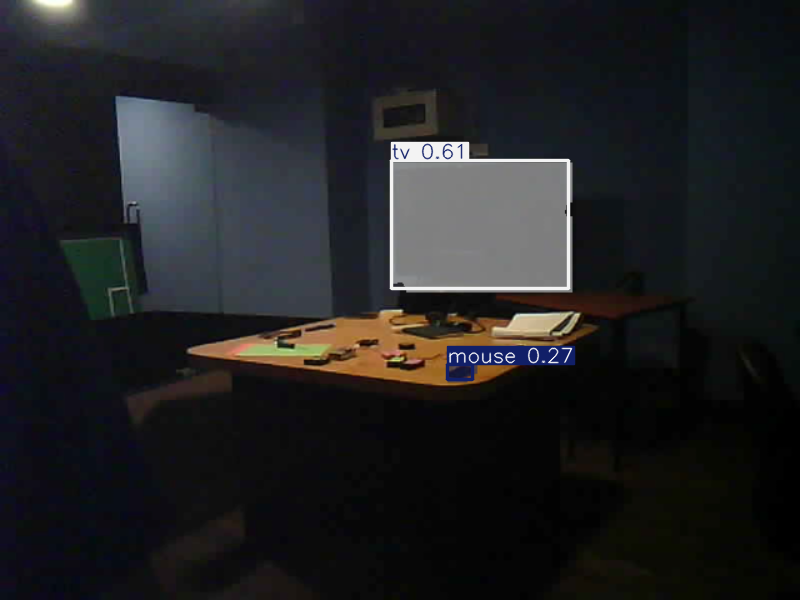

Speed: 2.0ms preprocess, 62.3ms inference, 75.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 laptop, 1 book, 17.9ms


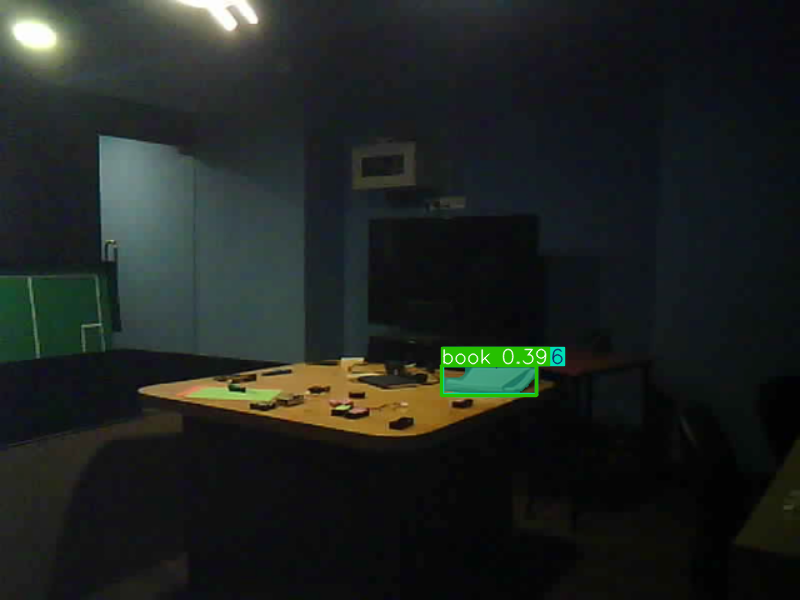

Speed: 2.0ms preprocess, 17.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 book, 67.0ms


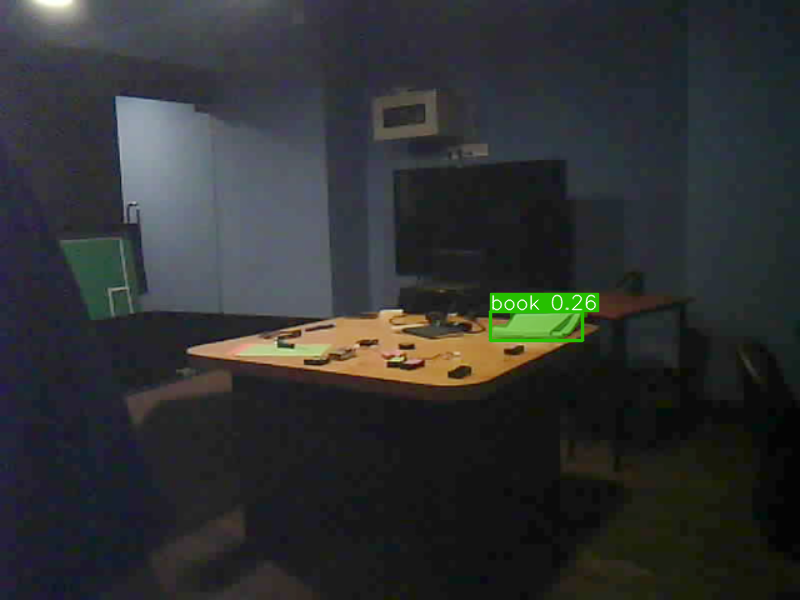

Speed: 3.0ms preprocess, 67.0ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 laptop, 1 book, 18.0ms


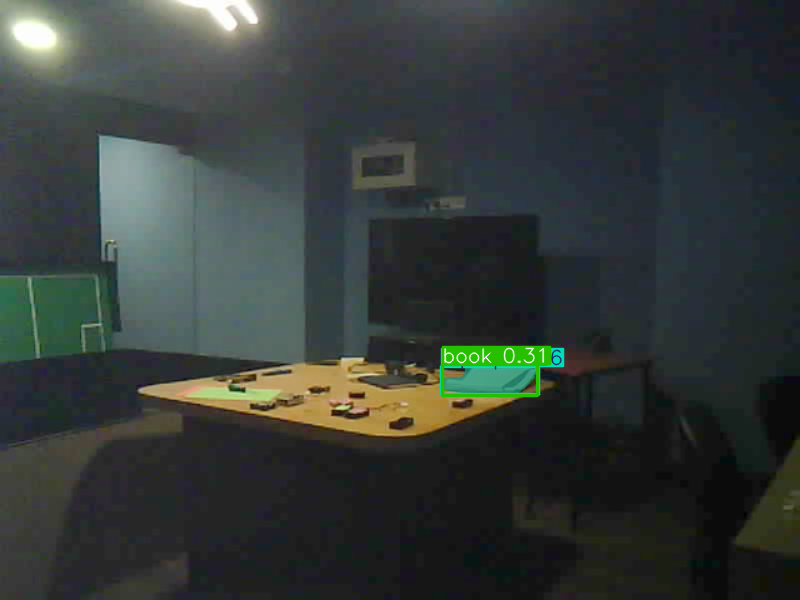

Speed: 2.0ms preprocess, 18.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


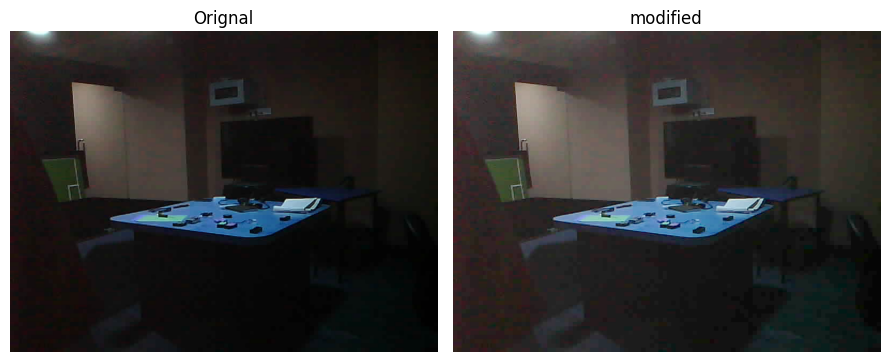

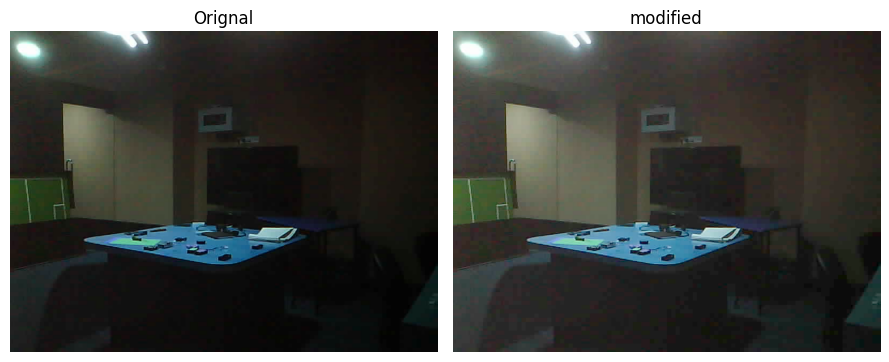

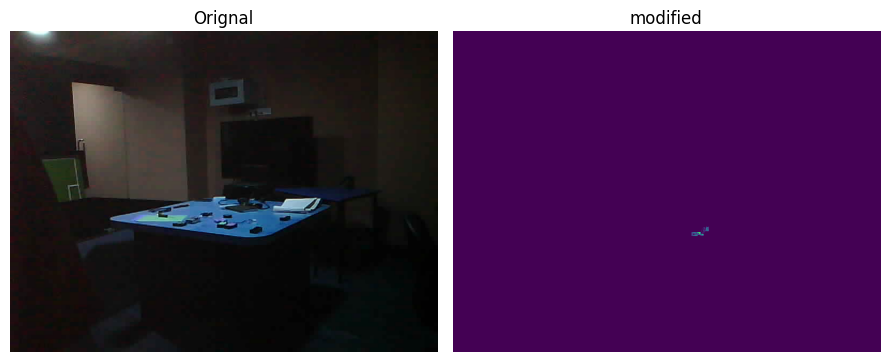

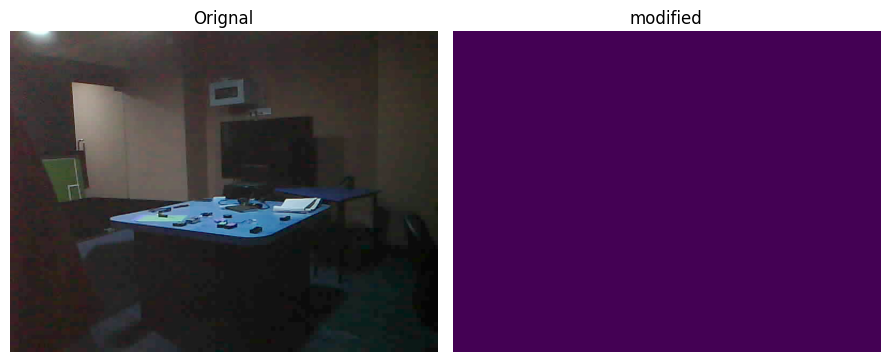

In [4]:
def segment_color(img, probability):
    temp = np.copy(img)
    model = YOLO('./models/yolo11m-seg.pt')
    results = model.predict(img, probability)
    for result in results:
        result.show()
        for mask, box in zip(result.masks.xy, result.boxes):
            points = np.int32([mask])
            cv.fillPoly(temp, points, 1)
    return temp - img

def contrastup(img, gamma):
    modified_img = np.array(np.clip(pow(img / 255.0, gamma) * 255.0, 0, 255), dtype=np.uint8)
    return modified_img

def scalelinear(img):
    max_intensity = np.max(img)
    min_intensity = np.min(img)
    modified = np.array(np.clip((img -min_intensity) * (255 / (max_intensity-min_intensity)), 0,  255), dtype=np.uint8)
    return modified

l_img = cv.imread("./images/imageOV2640R9.png")
r_img = cv.imread("./images/imageOV2640L9.png")

l_img_c = contrastup(l_img,0.7)
r_img_c = contrastup(r_img,0.7)

viewImages(l_img, l_img_c)
viewImages(r_img, r_img_c)

seg_l = np.array(segment_color(l_img, 0.1), dtype=np.uint8)
seg_r = np.array(segment_color(r_img, 0.1), dtype=np.uint8)
seg_l = cv.cvtColor(seg_l, cv.COLOR_BGR2GRAY)
seg_r = cv.cvtColor(seg_r, cv.COLOR_BGR2GRAY)
disparity = compute_disparity_NCC(seg_l, seg_r, 3, 400)
viewImages(l_img, disparity)

seg_l = np.array(segment_color(l_img_c, 0.1), dtype=np.uint8)
seg_r = np.array(segment_color(r_img_c, 0.1), dtype=np.uint8)
seg_l = cv.cvtColor(seg_l, cv.COLOR_BGR2GRAY)
seg_r = cv.cvtColor(seg_r, cv.COLOR_BGR2GRAY)
disparity = compute_disparity_NCC(seg_l, seg_r, 3, 400)
viewImages(l_img_c, disparity)


# Segments using Midas

Using cache found in C:\Users\IntelliSense04/.cache\torch\hub\intel-isl_MiDaS_master


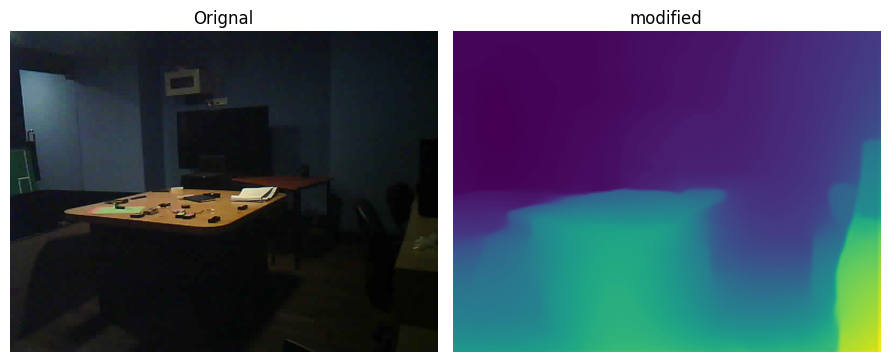

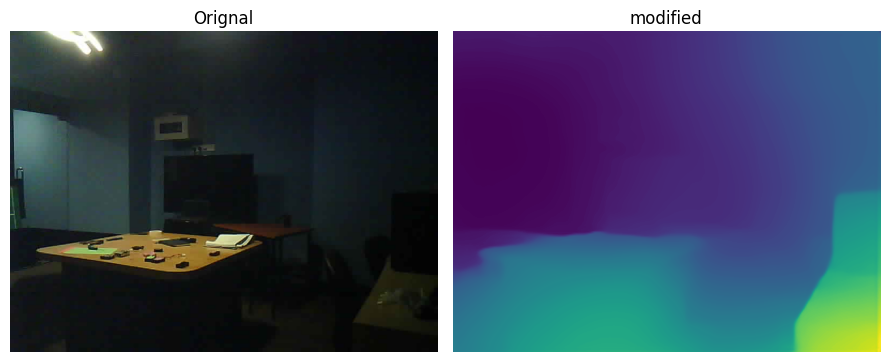

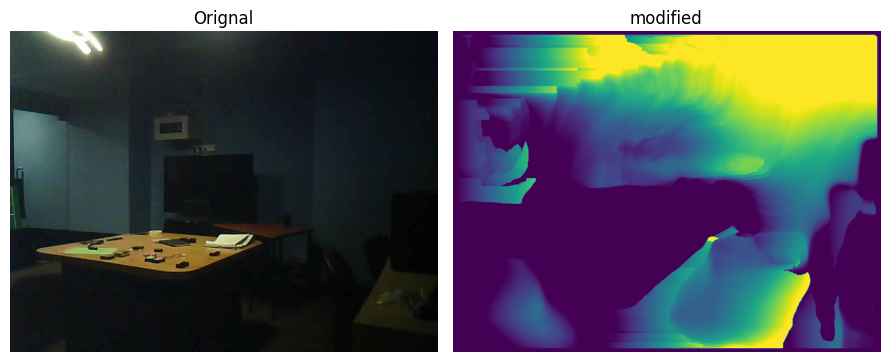

In [40]:
#model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
# model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

device = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

l_img = cv.imread("./images/imageOV2640R10.png")
r_img = cv.imread("./images/imageOV2640L10.png")

l_img = cv.cvtColor(l_img, cv.COLOR_BGR2RGB)
r_img = cv.cvtColor(r_img, cv.COLOR_BGR2RGB)

l_input_batch = transform(l_img).to(device)
r_input_batch = transform(r_img).to(device)

with torch.no_grad():
    prediction_l = midas(l_input_batch)
    prediction_r = midas(r_input_batch)

    prediction_l = torch.nn.functional.interpolate(
        prediction_l.unsqueeze(1),
        size=l_img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

    prediction_r = torch.nn.functional.interpolate(
        prediction_r.unsqueeze(1),
        size=r_img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

depth_map_l = prediction_l.cpu().numpy()
depth_map_r = prediction_r.cpu().numpy()

seg_img_l = cv.normalize(depth_map_l, None, 0, 1,
                            norm_type=cv.NORM_MINMAX, dtype=cv.CV_64F)
seg_img_r = cv.normalize(depth_map_r, None, 0, 1,
                            norm_type=cv.NORM_MINMAX, dtype=cv.CV_64F)

img = cv.cvtColor(l_img, cv.COLOR_RGB2BGR)
img = cv.cvtColor(r_img, cv.COLOR_RGB2BGR)

seg_img_l = (seg_img_l*255).astype(np.uint8)
seg_img_l = cv.applyColorMap(seg_img_l, cv.COLORMAP_MAGMA)
seg_img_l = cv.cvtColor(seg_img_l, cv.COLOR_BGR2GRAY)

seg_img_r = (seg_img_r*255).astype(np.uint8)
seg_img_r = cv.applyColorMap(seg_img_r, cv.COLORMAP_MAGMA)
seg_img_r = cv.cvtColor(seg_img_r, cv.COLOR_BGR2GRAY)

viewImages(l_img, seg_img_l)
viewImages(r_img, seg_img_r)